# Thesis: Training an Adapter for Cruise

This notebook documents the workflow for training a YOLO-based adapter model tailored for cruise applications. The process includes dataset preparation, configuration file creation, model training, and result management.

## Install Required Libraries

In this step, we will install the necessary libraries for training and evaluation. This includes the `ultralytics` package, which provides the YOLO implementation used in this workflow.

In [1]:
%%bash
ls /kaggle/input/*
mkdir -p dataset
cp -r /kaggle/input/*/* dataset/

classes.txt
test
train
valid


## Rename dataset 

In [2]:
import os
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Dataset root containing train/, valid/, test/
dataset_root = "dataset"
subsets = ["train", "valid", "test"]  # Remove "test" if not available
image_exts = ('.jpg', '.jpeg', '.png')

counter = 1  # Global counter for sequential naming

logging.info(f"Starting dataset renaming process in: {dataset_root}")

for subset in subsets:
    image_dir = os.path.join(dataset_root, subset, "images")
    label_dir = os.path.join(dataset_root, subset, "labels")

    if not os.path.exists(image_dir) or not os.path.exists(label_dir):
        logging.warning(f"Skipping '{subset}' due to missing images or labels directory")
        continue

    logging.info(f"Processing {subset} set...")
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(image_exts)])
    logging.info(f"Found {len(image_files)} images in {subset} set")

    for image_file in image_files:
        base_name, ext = os.path.splitext(image_file)
        txt_file = base_name + ".txt"

        # Generate new sequential names
        new_base = f"image-{counter:06d}"
        new_image_name = new_base + ext
        new_txt_name = new_base + ".txt"

        # Old paths
        old_image_path = os.path.join(image_dir, image_file)
        old_txt_path = os.path.join(label_dir, txt_file)

        # New paths
        new_image_path = os.path.join(image_dir, new_image_name)
        new_txt_path = os.path.join(label_dir, new_txt_name)

        try:
            # Rename image file
            os.rename(old_image_path, new_image_path)
            logging.debug(f"Renamed image: {image_file} -> {new_image_name}")

            # Rename corresponding label file if it exists
            if os.path.exists(old_txt_path):
                os.rename(old_txt_path, new_txt_path)
                logging.debug(f"Renamed label: {txt_file} -> {new_txt_name}")
            else:
                logging.warning(f"No label file found for: {image_file}")

            counter += 1

        except Exception as e:
            logging.error(f"Error renaming {image_file}: {str(e)}")

    logging.info(f"Completed processing {subset} set")

logging.info(f"Dataset renaming completed. Total files processed: {counter-1}")

In [3]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00


In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir models

<IPython.core.display.Javascript object>

In [5]:
from ultralytics import YOLO
import os
import cv2
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import shutil
import random
warnings.filterwarnings("ignore", category=RuntimeWarning)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Copy dataset from dataset save with kaggle

## Create YAML Configuration for Training

This section describes how to automatically generate a `data.yaml` configuration file required for YOLO training. The script reads class names from `classes.txt`, sets up dataset paths, and writes the configuration in YAML format.

In [6]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': 'dataset',
      'train': 'train/images',
      'val': 'valid/images',
      'test': 'test/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = 'dataset/classes.txt'
path_to_data_yaml = 'data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat data.yaml

Created config file at data.yaml

File contents:

path: dataset
train: train/images
val: valid/images
test: test/images
nc: 21
names:
- person
- bicycle
- car
- motorcycle
- bus
- truck
- stop sign
- other-vehicle
- crosswalk
- red light
- yellow light
- green light
- Speed limit 30km-h
- Speed limit 40km-h
- Speed limit 50km-h
- Speed limit 60km-h
- Speed limit 70km-h
- Speed limit 80km-h
- End of speed limit 60km-h
- End of speed limit 70km-h
- End of speed limit 80km-h


# Data Visualization

This section demonstrates how to visualize the training data with bounding boxes. The code will:

1. Load a random image from the training dataset
2. Read its corresponding label file
3. Draw bounding boxes and class labels on the image
4. Display the annotated image using matplotlib

This visualization helps verify that:
- Images are loading correctly
- Label files are properly formatted
- Bounding box coordinates are accurate
- Class IDs are valid

The visualization uses:
- OpenCV for image processing and drawing
- Matplotlib for display
- Green bounding boxes with class labels
- RGB color format for proper display

You can run the next cell to see a random training example with its annotations.


In [7]:
def load_classes(classes_path):
    """
    Load class names from classes.txt file.
    
    Args:
        classes_path (str): Path to the classes.txt file
    
    Returns:
        list: List of class names
    """
    if not os.path.exists(classes_path):
        print(f"Classes file {classes_path} not found!")
        return []
    
    with open(classes_path, 'r') as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

In [8]:
def visualize_random_samples(data_path, num_samples=6):
    """
    Visualize random samples from the dataset with bounding boxes in a 2x3 subplot.

    Args:
        data_path (str): Path to the dataset directory
        num_samples (int): Number of random samples to visualize (default=6 for 2x3 grid)
    """
    # Load class names
    classes_path = os.path.join(data_path, 'classes.txt')
    class_names = load_classes(classes_path)
    if not class_names:
        print("No class names loaded, using default class IDs.")
    
    # Load the images and labels
    images_path = os.path.join(data_path, 'train', 'images')
    labels_path = os.path.join(data_path, 'train', 'labels')

    # Get list of image files
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Select random images
    selected_images = random.sample(image_files, min(num_samples, len(image_files)))

    # Create a 2x3 subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()  # Flatten the 2x3 array for easier iteration

    for idx, random_image in enumerate(selected_images):
        image_path = os.path.join(images_path, random_image)
        label_path = os.path.join(labels_path, random_image.replace('.jpg', '.txt')
                                 .replace('.jpeg', '.txt').replace('.png', '.txt'))

        # Read and process the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Read labels and draw boxes
        num_objects = 0
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            height, width = img.shape[:2]
            for line in lines:
                class_id, x_center, y_center, w, h = map(float, line.strip().split())
                class_id = int(class_id)
                
                # Get class name or fallback to class ID
                class_label = class_names[class_id] if class_id < len(class_names) else f'Class {class_id}'

                # Convert normalized coordinates to pixel coordinates
                x1 = int((x_center - w/2) * width)
                y1 = int((y_center - h/2) * height)
                x2 = int((x_center + w/2) * width)
                y2 = int((y_center + h/2) * height)

                # Draw rectangle
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # Add class label
                cv2.putText(img, class_label, (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                num_objects += 1

        # Display image in subplot
        axes[idx].imshow(img)
        axes[idx].set_title(f'Image: {random_image}\nObjects: {num_objects}')
        axes[idx].axis('off')

        # Print image details
        print(f'Image {idx+1}:')
        print(f'Image shape: {img.shape}')
        print(f'Image path: {image_path}')
        print(f'Number of objects detected: {num_objects}\n')

    # Hide empty subplots if fewer images than num_samples
    for idx in range(len(selected_images), 6):
        axes[idx].axis('off')
        axes[idx].set_visible(False)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

Image 1:
Image shape: (640, 640, 3)
Image path: dataset/train/images/image-006877.jpg
Number of objects detected: 4

Image 2:
Image shape: (640, 640, 3)
Image path: dataset/train/images/image-002522.jpg
Number of objects detected: 5

Image 3:
Image shape: (640, 640, 3)
Image path: dataset/train/images/image-002443.jpg
Number of objects detected: 5

Image 4:
Image shape: (640, 640, 3)
Image path: dataset/train/images/image-005243.jpg
Number of objects detected: 4

Image 5:
Image shape: (640, 640, 3)
Image path: dataset/train/images/image-001250.jpg
Number of objects detected: 9

Image 6:
Image shape: (640, 640, 3)
Image path: dataset/train/images/image-006896.jpg
Number of objects detected: 4



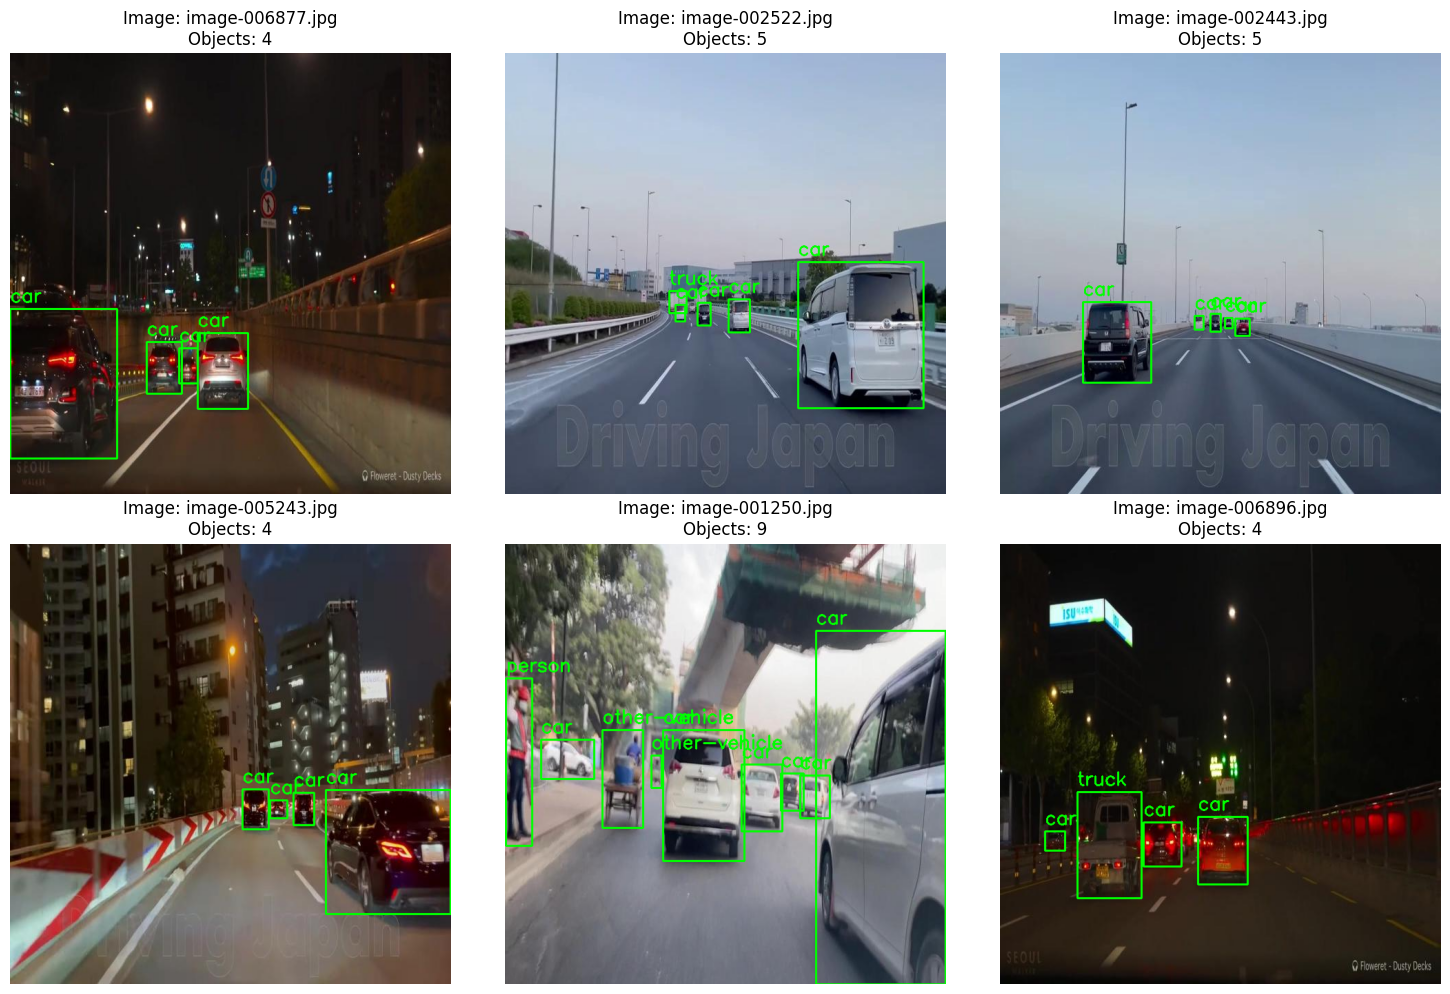

In [9]:
data_path = 'dataset'
visualize_random_samples(data_path, num_samples=6)

## Start YOLO model training

The model and training parameters are defined in the cell below.
Please run the next cell to begin training.

In [10]:
# Load pretrained model (better starting point than from scratch)
model = YOLO("yolo11n.pt")  # or "yolo11n.pt" for standard YOLOv11

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.4MB/s]


In [11]:
# # Train the model with optimized parameters
model.train(
    data="data.yaml",       # Path to dataset config file
    epochs=350,             # Number of training epochs
    imgsz=640,              # Input image size (square: 640x640)
    batch=16,               # Batch size (adjust based on GPU memory)
    device=[0, 1],          # Use GPU 0 and GPU 1
    patience=100,            # Stop early if no improvement in 50 epochs
    project="models",
    optimizer="auto",       # Let YOLO choose the best optimizer
    lr0=0.01                # Initial learning rate
)


Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=350, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

100%|██████████| 755k/755k [00:00<00:00, 18.3MB/s]


Overriding model.yaml nc=80 with nc=21

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/dataset/train/labels... 7108 images, 3 backgrounds, 0 corrupt: 100%|██████████| 7108/7108 [00:05<00:00, 1281.44it/s]


train: /kaggle/working/dataset/train/images/image-004669.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/image-005897.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/image-006778.jpg: 1 duplicate labels removed
train: /kaggle/working/dataset/train/images/image-006858.jpg: 1 duplicate labels removed
train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 690.2±258.4 MB/s, size: 37.7 KB)


val: Scanning /kaggle/working/dataset/valid/labels... 1928 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1928/1928 [00:01<00:00, 1384.26it/s]


val: /kaggle/working/dataset/valid/images/image-008340.jpg: 1 duplicate labels removed
val: New cache created: /kaggle/working/dataset/valid/labels.cache
Plotting labels to models/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to models/train
Starting training for 350 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/350       1.3G      1.044      2.568       1.04         10        640: 100%|██████████| 445/445 [01:28<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:15<00:00,  7.79it/s]


                   all       1928       9335      0.366      0.243      0.202      0.142

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/350       1.5G      1.012      1.477      1.039         17        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.34it/s]


                   all       1928       9335      0.579      0.229      0.236      0.153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/350      1.51G      1.069      1.454      1.067          4        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.49it/s]


                   all       1928       9335      0.652      0.228      0.206      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/350      1.52G      1.106      1.392      1.094         19        640: 100%|██████████| 445/445 [01:22<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.45it/s]


                   all       1928       9335      0.312       0.32      0.255      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/350      1.54G      1.056      1.226      1.066         17        640: 100%|██████████| 445/445 [01:21<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.50it/s]


                   all       1928       9335      0.376      0.291      0.281      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/350      1.54G      1.021       1.11      1.057         10        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.53it/s]


                   all       1928       9335      0.511      0.328      0.302      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/350      1.55G      1.017      1.048      1.055         13        640: 100%|██████████| 445/445 [01:22<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335      0.533      0.323      0.328      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/350      1.55G      0.979     0.9806      1.039          5        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.499      0.371      0.337      0.229

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/350      1.57G     0.9773     0.9659      1.041          5        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.52it/s]


                   all       1928       9335      0.477      0.357      0.347      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/350      1.58G     0.9423     0.9144      1.024          9        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.77it/s]


                   all       1928       9335      0.581      0.381      0.384      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/350      1.59G     0.9454     0.8925      1.023         14        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.64it/s]


                   all       1928       9335       0.56       0.38       0.39      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/350      1.59G     0.9327     0.8744       1.02          5        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335       0.59      0.387      0.404      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/350      1.61G     0.9131     0.8566      1.018         30        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335      0.539      0.413      0.411      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/350      1.62G      0.907     0.8304      1.006         13        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.48it/s]


                   all       1928       9335       0.62       0.41      0.435      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/350      1.63G     0.8859     0.8018     0.9995         16        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.603      0.407      0.419      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/350      1.63G     0.8999     0.8071      1.001         20        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.60it/s]


                   all       1928       9335      0.654      0.382      0.426      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/350      1.65G     0.8758     0.7953     0.9976          3        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.635      0.434      0.452      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/350      1.66G     0.8829     0.7893     0.9959          8        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.602      0.438       0.45      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/350      1.67G     0.8817     0.7812     0.9944         10        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.661      0.429      0.467      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/350      1.67G     0.8797     0.7874     0.9934          7        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.678      0.411      0.463      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/350      1.69G     0.8597     0.7518      0.986         28        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.68it/s]


                   all       1928       9335      0.671      0.423      0.468      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/350       1.7G     0.8687     0.7588     0.9916          7        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.623      0.436      0.467      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/350      1.71G     0.8442     0.7371     0.9837         16        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.596      0.481      0.477      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/350      1.71G     0.8485     0.7413     0.9844          7        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.63it/s]


                   all       1928       9335      0.655      0.428       0.48      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/350      1.73G     0.8585     0.7332     0.9869          5        640: 100%|██████████| 445/445 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.52it/s]


                   all       1928       9335      0.675      0.443      0.491      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/350      1.74G     0.8624     0.7455       0.99          9        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.40it/s]


                   all       1928       9335      0.657      0.445      0.505      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/350      1.75G     0.8549     0.7451      0.984          4        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.714      0.434      0.516      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/350      1.75G     0.8313     0.7145     0.9762          6        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.50it/s]


                   all       1928       9335      0.675       0.45      0.504      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/350      1.77G     0.8448     0.7215     0.9774         16        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.51it/s]


                   all       1928       9335       0.61      0.468      0.512      0.366

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/350      1.78G     0.8371     0.7127     0.9792         12        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.701      0.453      0.528      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/350      1.79G     0.8444     0.7258     0.9801          8        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.64it/s]


                   all       1928       9335      0.709      0.466      0.531      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/350      1.79G     0.8312     0.7096     0.9738          4        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.46it/s]


                   all       1928       9335      0.705      0.458      0.536      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/350      1.81G     0.8238     0.6995     0.9702         12        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.44it/s]


                   all       1928       9335      0.631      0.455      0.514      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/350      1.82G     0.8258       0.71      0.973         20        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.65it/s]


                   all       1928       9335      0.672      0.466      0.523      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/350      1.83G     0.8157      0.688     0.9653         13        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.60it/s]


                   all       1928       9335      0.683       0.48       0.54      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/350      1.83G     0.8256     0.6976     0.9715          6        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.685      0.464      0.534      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/350      1.85G     0.8193     0.6934     0.9721         16        640: 100%|██████████| 445/445 [01:24<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335      0.734      0.445      0.522      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/350      1.86G     0.8131     0.6904     0.9673         36        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335      0.667      0.474      0.543      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/350      1.87G     0.8187     0.6722     0.9675         16        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.84it/s]


                   all       1928       9335      0.757      0.466       0.54      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/350      1.87G     0.8217      0.685      0.974         30        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.89it/s]


                   all       1928       9335      0.754      0.474      0.545      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/350      1.89G     0.8061     0.6752     0.9648          6        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.89it/s]


                   all       1928       9335      0.706       0.47      0.547      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/350       1.9G     0.8224     0.6826     0.9708          6        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.773      0.453      0.547      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/350      1.91G     0.8009     0.6719     0.9559          7        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.721      0.484      0.561      0.407


     44/350      1.91G     0.6745     0.5997     0.9409         41        640:   0%|          | 1/445 [00:00<01:20,  5.52it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/350      1.91G     0.7897     0.6629     0.9561         13        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335      0.686      0.512      0.563      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/350      1.93G     0.8107     0.6715     0.9665         15        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.73it/s]


                   all       1928       9335      0.679      0.487       0.54       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/350      1.94G     0.7918     0.6586     0.9544          5        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335      0.717      0.518       0.56      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/350      1.95G     0.7902     0.6587     0.9557         26        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


                   all       1928       9335      0.735      0.496      0.561      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/350      1.95G     0.8113     0.6667     0.9622         15        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.716      0.491      0.556      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/350      1.97G      0.802     0.6506     0.9586          3        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.89it/s]


                   all       1928       9335      0.792      0.475      0.558      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/350      1.98G     0.7822     0.6349     0.9518          5        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.84it/s]


                   all       1928       9335      0.767      0.483      0.561      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/350      1.99G     0.7915     0.6551     0.9562          7        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335      0.797      0.485      0.566      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/350      1.99G     0.7938     0.6476     0.9575          5        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


                   all       1928       9335      0.807      0.466       0.56      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/350      2.01G     0.8112      0.661     0.9649          8        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  9.06it/s]


                   all       1928       9335      0.692      0.522      0.567       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/350      2.02G     0.7908     0.6435     0.9544         11        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.63it/s]


                   all       1928       9335      0.736      0.501      0.568      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/350      2.03G     0.7873     0.6455     0.9571         11        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335       0.72      0.512      0.565      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/350      2.03G     0.7847     0.6439     0.9487         30        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.59it/s]


                   all       1928       9335      0.709      0.545      0.585       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/350      2.05G     0.7864     0.6396     0.9539         19        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.755      0.501      0.591      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/350      2.06G     0.7905      0.648     0.9572          9        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.70it/s]


                   all       1928       9335      0.733      0.517      0.585       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/350      2.07G      0.778     0.6375     0.9536         21        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.70it/s]


                   all       1928       9335      0.766      0.519      0.586      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/350      2.07G     0.7671     0.6228     0.9425         12        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.45it/s]


                   all       1928       9335      0.745      0.493      0.569      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/350      2.09G     0.7792     0.6294     0.9497         26        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.715      0.524      0.584      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/350       2.1G     0.7749     0.6356     0.9501         16        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.40it/s]


                   all       1928       9335      0.722      0.534       0.59      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/350      2.11G     0.7934     0.6392     0.9575          8        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


                   all       1928       9335      0.713       0.53      0.588       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/350      2.11G     0.7867     0.6368     0.9509         11        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.70it/s]


                   all       1928       9335      0.726      0.547      0.604      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/350      2.13G     0.7788     0.6351     0.9501         11        640: 100%|██████████| 445/445 [01:23<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.748       0.53      0.628      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/350      2.14G     0.7639     0.6177      0.943         13        640: 100%|██████████| 445/445 [01:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.82it/s]


                   all       1928       9335        0.7      0.542      0.618       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/350      2.15G     0.7682     0.6238     0.9475          8        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.63it/s]


                   all       1928       9335      0.674      0.582      0.606      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/350      2.15G     0.7911     0.6291     0.9549         20        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.78it/s]


                   all       1928       9335      0.728      0.551      0.609      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/350      2.17G     0.7638     0.6177     0.9429         13        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.84it/s]


                   all       1928       9335      0.732      0.532      0.616      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/350      2.18G     0.7848     0.6228     0.9516         15        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.83it/s]


                   all       1928       9335      0.747      0.529      0.618      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/350      2.19G     0.7657     0.6218     0.9501          7        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.721      0.533      0.599      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/350      2.19G     0.7737     0.6164     0.9453          9        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.741      0.543      0.606      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/350      2.21G     0.7734     0.6204     0.9466         23        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.77it/s]


                   all       1928       9335      0.761      0.524      0.625      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/350      2.22G     0.7527     0.6063     0.9423          7        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.87it/s]


                   all       1928       9335       0.77      0.514      0.632      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/350      2.23G      0.766     0.6128     0.9434         25        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.77it/s]


                   all       1928       9335      0.753      0.525      0.625      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/350      2.23G     0.7547     0.6097     0.9394          8        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


                   all       1928       9335      0.731      0.534      0.635      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/350      2.25G     0.7684     0.6088     0.9443         15        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.88it/s]


                   all       1928       9335      0.762      0.527      0.636      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/350      2.26G     0.7619     0.6069      0.943         15        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.73it/s]


                   all       1928       9335      0.718      0.554      0.629      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/350      2.27G       0.76     0.6026     0.9401          7        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.50it/s]


                   all       1928       9335       0.73       0.55      0.639      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/350      2.27G     0.7562     0.6071     0.9435          2        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


                   all       1928       9335      0.744       0.55      0.658      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/350      2.29G     0.7644     0.6012     0.9441         10        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.55it/s]


                   all       1928       9335       0.76      0.537      0.644      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/350       2.3G     0.7591     0.6046     0.9428         14        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335       0.73      0.558      0.655      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/350      2.31G     0.7552     0.5942     0.9389         17        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335      0.756      0.548      0.644      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/350      2.31G     0.7566     0.6005     0.9393         39        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.55it/s]


                   all       1928       9335      0.757      0.543      0.664       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/350      2.33G     0.7509     0.5947     0.9405          9        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.735      0.559      0.673      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/350      2.34G     0.7572     0.6054     0.9439          8        640: 100%|██████████| 445/445 [01:23<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.686      0.591      0.694      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/350      2.35G     0.7451     0.5888     0.9384         19        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.53it/s]


                   all       1928       9335      0.747       0.55      0.678      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/350      2.35G     0.7491     0.5979     0.9345         14        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.676      0.615       0.68      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/350      2.37G     0.7526     0.5963     0.9394          8        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.52it/s]


                   all       1928       9335      0.623      0.623      0.679      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/350      2.38G     0.7469     0.5993     0.9391         11        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.545      0.658       0.67      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/350      2.39G     0.7502     0.5944     0.9368          5        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335      0.563      0.666      0.668      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/350      2.39G     0.7455     0.5955     0.9378         14        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.79it/s]


                   all       1928       9335      0.568      0.664      0.671      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/350      2.41G     0.7452      0.595     0.9344         17        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335       0.58      0.693       0.68      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/350      2.42G     0.7494     0.5949     0.9389         29        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.79it/s]


                   all       1928       9335      0.651      0.657      0.688      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/350      2.43G     0.7442     0.5848      0.936         15        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.713      0.614      0.686      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/350      2.43G     0.7444     0.5913     0.9365          7        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.60it/s]


                   all       1928       9335      0.721      0.618      0.688      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/350      2.45G     0.7504     0.5938     0.9331          7        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.59it/s]


                   all       1928       9335      0.583      0.676      0.693      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/350      2.46G     0.7509     0.5912     0.9391         13        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.70it/s]


                   all       1928       9335      0.594       0.66      0.675        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/350      2.47G     0.7404     0.5834     0.9375         17        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335      0.705      0.636      0.677      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/350      2.47G     0.7477      0.588     0.9381         11        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.91it/s]


                   all       1928       9335      0.737      0.616      0.689      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/350      2.48G     0.7386     0.5846     0.9334          4        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.50it/s]


                   all       1928       9335       0.77      0.605      0.709      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/350       2.5G     0.7432     0.5843     0.9345         12        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.59it/s]


                   all       1928       9335      0.748      0.616       0.71      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/350      2.51G     0.7414     0.5857     0.9365          4        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.45it/s]


                   all       1928       9335      0.767      0.602      0.709      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/350      2.51G     0.7342     0.5775     0.9354          4        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.89it/s]


                   all       1928       9335      0.767      0.605      0.716      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/350      2.53G     0.7445     0.5816     0.9346         32        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.49it/s]


                   all       1928       9335      0.726      0.633      0.718      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/350      2.54G      0.734     0.5823     0.9326         17        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.725      0.633      0.716      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/350      2.55G     0.7475     0.5798     0.9365          8        640: 100%|██████████| 445/445 [01:26<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.48it/s]


                   all       1928       9335      0.734      0.628      0.709      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/350      2.55G     0.7317     0.5711     0.9261          7        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.53it/s]


                   all       1928       9335      0.733       0.63      0.711      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/350      2.57G     0.7351     0.5745     0.9328         17        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.51it/s]


                   all       1928       9335      0.731      0.636      0.711      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/350      2.58G     0.7342     0.5712     0.9295         11        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.33it/s]


                   all       1928       9335      0.744      0.627       0.71      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/350      2.59G     0.7309     0.5657     0.9263         23        640: 100%|██████████| 445/445 [01:25<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.37it/s]


                   all       1928       9335      0.752      0.624      0.703      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/350      2.59G     0.7399      0.569      0.932          9        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.40it/s]


                   all       1928       9335      0.738      0.628      0.712      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/350       2.6G     0.7264     0.5684     0.9318         17        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.56it/s]


                   all       1928       9335      0.746      0.626      0.711      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/350      2.62G     0.7317     0.5647     0.9269          8        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335       0.67      0.685      0.711      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/350      2.63G     0.7139     0.5593     0.9262         10        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335      0.711      0.641      0.711      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/350      2.63G     0.7196     0.5616      0.923         13        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.87it/s]


                   all       1928       9335      0.719       0.64      0.713      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/350      2.64G     0.7236      0.566      0.927         12        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.742      0.628      0.713      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/350      2.66G     0.7195     0.5599     0.9252         22        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  9.05it/s]


                   all       1928       9335      0.739       0.63      0.714      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/350      2.67G     0.7258      0.561     0.9317         18        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.77it/s]


                   all       1928       9335      0.743      0.637      0.716      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/350      2.67G     0.7385     0.5751     0.9306         19        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.735      0.643      0.726      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/350      2.68G     0.7203     0.5606     0.9263          3        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.28it/s]


                   all       1928       9335      0.701      0.682      0.715      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/350       2.7G     0.7124     0.5538     0.9266         13        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


                   all       1928       9335      0.703      0.679      0.715      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/350      2.71G     0.7218     0.5651     0.9241         19        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.34it/s]


                   all       1928       9335      0.697      0.682      0.717      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/350      2.71G     0.7368     0.5708     0.9275          6        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.47it/s]


                   all       1928       9335      0.693      0.686      0.715      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/350      2.72G     0.7042     0.5444     0.9189         13        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335      0.692      0.689      0.714      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/350      2.74G     0.7217     0.5553     0.9261         17        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335      0.691      0.693      0.714      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/350      2.74G     0.7102     0.5521     0.9245         17        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.685      0.695      0.709      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/350      2.75G     0.7154     0.5522      0.923         15        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335      0.624      0.693      0.713      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/350      2.76G     0.7211     0.5556     0.9251         25        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.627      0.696      0.713      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/350      2.78G     0.7186     0.5596     0.9258         10        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.51it/s]


                   all       1928       9335       0.63      0.693      0.713      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/350      2.79G     0.7123     0.5414     0.9255         15        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.42it/s]


                   all       1928       9335      0.641      0.689      0.714      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/350      2.79G     0.7129     0.5544     0.9223          7        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.47it/s]


                   all       1928       9335      0.714       0.68      0.714      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/350       2.8G     0.7167      0.554     0.9235         12        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335      0.719      0.672      0.715      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/350      2.81G     0.7266     0.5587     0.9281         22        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335       0.72      0.669      0.725      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/350      2.82G     0.7221     0.5503     0.9276         18        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.65it/s]


                   all       1928       9335      0.715      0.678      0.726       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/350      2.82G      0.718      0.559     0.9263          6        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.55it/s]


                   all       1928       9335      0.716      0.676      0.725       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/350      2.84G      0.719     0.5532     0.9285         13        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.716      0.671      0.725      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/350      2.86G     0.7182     0.5521     0.9257         18        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.41it/s]


                   all       1928       9335      0.699      0.687      0.725      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/350      2.86G     0.7108     0.5533     0.9201         11        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


                   all       1928       9335      0.709      0.677      0.725       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/350      2.87G     0.7063     0.5379     0.9179         19        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.77it/s]


                   all       1928       9335      0.713      0.676      0.727      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/350      2.89G     0.7108      0.547     0.9229         18        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.70it/s]


                   all       1928       9335      0.716      0.673      0.718      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/350      2.89G     0.7257     0.5561      0.928         17        640: 100%|██████████| 445/445 [01:26<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335      0.719      0.673      0.726      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/350       2.9G     0.7137     0.5473      0.922         35        640: 100%|██████████| 445/445 [01:26<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335       0.72      0.673      0.727      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/350       2.9G     0.7142     0.5473     0.9203         32        640: 100%|██████████| 445/445 [01:26<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.51it/s]


                   all       1928       9335      0.724      0.668      0.728      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/350      2.93G     0.7121     0.5485     0.9236         16        640: 100%|██████████| 445/445 [01:26<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.35it/s]


                   all       1928       9335      0.724      0.668      0.728      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/350      2.94G     0.7021     0.5364     0.9152         18        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.47it/s]


                   all       1928       9335      0.722      0.672      0.715       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/350      2.94G     0.7271      0.555     0.9254         19        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.53it/s]


                   all       1928       9335      0.725      0.671      0.715       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/350      2.95G     0.7128     0.5547     0.9237         12        640: 100%|██████████| 445/445 [01:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.83it/s]


                   all       1928       9335      0.726      0.672      0.715       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/350      2.96G     0.7046     0.5368     0.9165         28        640: 100%|██████████| 445/445 [01:27<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.726       0.67      0.714      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/350      2.97G     0.7034     0.5383     0.9158          5        640: 100%|██████████| 445/445 [01:27<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.725      0.672      0.714      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/350      2.98G     0.7097     0.5408     0.9185         11        640: 100%|██████████| 445/445 [01:26<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335      0.728       0.67      0.715       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/350      2.98G     0.7117     0.5383     0.9204          8        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.56it/s]


                   all       1928       9335      0.725      0.669      0.714      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/350         3G     0.7013     0.5378     0.9176         25        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.32it/s]


                   all       1928       9335      0.725      0.669      0.715      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/350      3.01G     0.7013     0.5443     0.9187          6        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.27it/s]


                   all       1928       9335      0.728      0.667      0.715      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/350      3.03G     0.7077     0.5407     0.9168         13        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.79it/s]


                   all       1928       9335      0.726      0.668      0.715      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/350      3.03G     0.7031     0.5382     0.9196          7        640: 100%|██████████| 445/445 [01:26<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.83it/s]


                   all       1928       9335      0.727      0.666       0.71      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/350      3.04G     0.6998     0.5352     0.9162         22        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335      0.727      0.668      0.715      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/350      3.06G      0.699     0.5304     0.9153         16        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.45it/s]


                   all       1928       9335      0.728      0.667      0.709      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/350      3.06G     0.7055     0.5302     0.9169          7        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335      0.723      0.671       0.71      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/350      3.07G     0.6997     0.5287     0.9123         21        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.726       0.67       0.71      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/350      3.08G     0.7085     0.5336     0.9165         26        640: 100%|██████████| 445/445 [01:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.65it/s]


                   all       1928       9335      0.726      0.671      0.711      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/350      3.09G     0.6943      0.531     0.9132         10        640: 100%|██████████| 445/445 [01:26<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.729      0.669      0.711      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/350       3.1G     0.6956     0.5297     0.9173         12        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.43it/s]


                   all       1928       9335      0.729      0.669      0.711      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/350       3.1G     0.6945     0.5288     0.9108          9        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.44it/s]


                   all       1928       9335      0.729       0.67      0.711      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/350      3.12G     0.7024     0.5271     0.9183          6        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.728      0.671      0.711      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/350      3.13G     0.6921     0.5249     0.9159          6        640: 100%|██████████| 445/445 [01:27<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.68it/s]


                   all       1928       9335      0.727      0.674      0.711      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/350      3.14G     0.6846     0.5214     0.9132         25        640: 100%|██████████| 445/445 [01:26<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.48it/s]


                   all       1928       9335      0.727      0.676      0.716      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/350      3.14G     0.7038      0.538     0.9184          8        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.50it/s]


                   all       1928       9335      0.729      0.674      0.716      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/350      3.16G      0.697     0.5291     0.9137          4        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.48it/s]


                   all       1928       9335      0.723       0.68      0.716      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/350      3.17G     0.7004     0.5327     0.9171          8        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.59it/s]


                   all       1928       9335      0.722       0.68      0.716      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/350      3.19G     0.6886     0.5273     0.9146         12        640: 100%|██████████| 445/445 [01:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.64it/s]


                   all       1928       9335      0.726      0.674      0.715      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/350      3.19G     0.6956     0.5234     0.9173          5        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.44it/s]


                   all       1928       9335      0.727      0.675      0.717      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/350       3.2G     0.6969     0.5304     0.9171         20        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.37it/s]


                   all       1928       9335      0.728      0.673      0.717      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/350      3.21G      0.697     0.5242     0.9147         14        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.47it/s]


                   all       1928       9335      0.726      0.676      0.717      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/350      3.22G     0.6896     0.5279     0.9141          7        640: 100%|██████████| 445/445 [01:26<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335      0.727      0.678      0.717      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/350      3.22G     0.7048     0.5301      0.918         10        640: 100%|██████████| 445/445 [01:27<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.723       0.68      0.717      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/350      3.24G      0.692     0.5239     0.9145          9        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335      0.724       0.68      0.719      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/350      3.25G     0.6875     0.5242     0.9092         11        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.46it/s]


                   all       1928       9335      0.724      0.679      0.719       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/350      3.26G     0.6864      0.514     0.9134          9        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.68it/s]


                   all       1928       9335      0.725      0.679      0.719       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/350      3.26G     0.6945     0.5225     0.9146         10        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.725      0.679      0.718       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/350      3.29G     0.6863     0.5154     0.9076         27        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.53it/s]


                   all       1928       9335      0.724       0.68      0.718       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/350      3.29G     0.6804      0.517     0.9083          4        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


                   all       1928       9335      0.725       0.68      0.719       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/350       3.3G     0.6972      0.526     0.9148         15        640: 100%|██████████| 445/445 [01:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.68it/s]


                   all       1928       9335      0.726       0.68      0.719      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/350       3.3G     0.6925     0.5262     0.9188         27        640: 100%|██████████| 445/445 [01:27<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.63it/s]


                   all       1928       9335      0.725       0.68      0.718      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/350      3.32G     0.6783     0.5153     0.9086         10        640: 100%|██████████| 445/445 [01:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.70it/s]


                   all       1928       9335      0.727      0.679      0.719      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/350      3.34G     0.6822      0.515     0.9109         19        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.78it/s]


                   all       1928       9335      0.725       0.68      0.719       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/350      3.34G     0.6872     0.5126     0.9128          3        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.726      0.679      0.719      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/350      3.34G     0.6875     0.5114      0.911          7        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.50it/s]


                   all       1928       9335      0.725       0.68      0.719      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/350      3.37G     0.6871      0.516     0.9124         20        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.63it/s]


                   all       1928       9335      0.726       0.68      0.721      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/350      3.37G     0.6778      0.506     0.9094         14        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.728      0.679      0.721      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/350      3.38G     0.6967     0.5215     0.9145         11        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.727      0.679      0.721      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/350      3.38G     0.6861     0.5168     0.9119          9        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.88it/s]


                   all       1928       9335      0.725       0.68      0.721      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/350       3.4G     0.6816     0.5103     0.9097          5        640: 100%|██████████| 445/445 [01:26<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.725       0.68      0.721      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/350      3.41G     0.6851       0.51      0.908         17        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.81it/s]


                   all       1928       9335      0.731      0.675      0.721      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/350      3.42G     0.6912     0.5238     0.9158          4        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.55it/s]


                   all       1928       9335      0.714      0.689      0.721      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/350      3.42G     0.6759     0.5104      0.907         16        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.87it/s]


                   all       1928       9335      0.713      0.689      0.721      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/350      3.44G     0.6755      0.508     0.9092         19        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.49it/s]


                   all       1928       9335      0.713      0.687      0.722      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/350      3.45G     0.6816     0.5141     0.9098         19        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.83it/s]


                   all       1928       9335      0.714      0.687      0.722      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/350      3.46G     0.6787     0.5092     0.9095         11        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.46it/s]


                   all       1928       9335      0.711      0.688      0.722      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/350      3.46G     0.6719     0.4976     0.9055         23        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.87it/s]


                   all       1928       9335      0.711      0.688      0.722      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/350      3.48G     0.6945     0.5196     0.9142          6        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.36it/s]


                   all       1928       9335      0.711      0.688      0.722      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/350      3.49G     0.6932     0.5112     0.9119         10        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.63it/s]


                   all       1928       9335      0.714      0.688      0.722      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/350       3.5G     0.6826     0.5045     0.9104          4        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.68it/s]


                   all       1928       9335      0.715      0.687      0.722       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/350       3.5G     0.6785     0.5098     0.9057         24        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335      0.714      0.689      0.723      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/350      3.52G     0.6845     0.5062     0.9103         44        640: 100%|██████████| 445/445 [01:23<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.714      0.689      0.723      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/350      3.53G     0.6775     0.5077     0.9106         45        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.78it/s]


                   all       1928       9335      0.717      0.688      0.723      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/350      3.54G     0.6724     0.5017     0.9084          8        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.68it/s]


                   all       1928       9335      0.718      0.689      0.723      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/350      3.54G     0.6809     0.5068     0.9094         16        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.719      0.689      0.724      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/350      3.56G     0.6699     0.4952     0.9048         11        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335       0.72      0.688      0.724      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/350      3.57G     0.6838     0.5103     0.9111         50        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.64it/s]


                   all       1928       9335       0.72      0.687      0.725      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/350      3.58G     0.6753     0.5024     0.9064          8        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335       0.72      0.687      0.715      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/350      3.58G      0.672     0.4914     0.9052          6        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.661      0.687      0.715      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/350       3.6G     0.6635     0.4888      0.902         16        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.67it/s]


                   all       1928       9335      0.676      0.691      0.715      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/350      3.61G      0.676     0.5019       0.91          8        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335       0.68      0.695      0.716      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/350      3.62G     0.6667      0.494     0.9061         24        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.78it/s]


                   all       1928       9335      0.677      0.697      0.716      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/350      3.62G     0.6654     0.4968     0.9056         24        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335      0.677      0.696      0.714      0.533


    217/350      3.62G     0.5829     0.4637     0.8165         47        640:   0%|          | 1/445 [00:00<01:14,  5.94it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/350      3.64G     0.6592     0.4851     0.9059         11        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.65it/s]


                   all       1928       9335      0.676      0.697      0.714      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/350      3.65G     0.6614     0.4903     0.9004         20        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.26it/s]


                   all       1928       9335      0.673      0.697      0.713      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/350      3.66G      0.659     0.4866     0.9035         17        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.671      0.697      0.714      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/350      3.66G     0.6677     0.4987      0.906          8        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.65it/s]


                   all       1928       9335      0.669      0.697      0.723      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/350      3.68G     0.6677     0.4919     0.9032         10        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.75it/s]


                   all       1928       9335      0.667      0.698      0.712       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/350      3.69G       0.67     0.4964     0.9036          8        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.666      0.697      0.713      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/350       3.7G     0.6662     0.4906     0.9042         16        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.77it/s]


                   all       1928       9335      0.666      0.696      0.712       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/350      3.71G     0.6624     0.4926     0.9041         15        640: 100%|██████████| 445/445 [01:26<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.59it/s]


                   all       1928       9335       0.67      0.693      0.713      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/350      3.72G     0.6686     0.4929     0.9025          1        640: 100%|██████████| 445/445 [01:27<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.86it/s]


                   all       1928       9335      0.673      0.691      0.713       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/350      3.73G     0.6533     0.4797     0.8986          2        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.75it/s]


                   all       1928       9335      0.674       0.69      0.713      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/350      3.74G       0.66     0.4859     0.9024          8        640: 100%|██████████| 445/445 [01:27<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.56it/s]


                   all       1928       9335      0.674      0.689      0.723      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/350      3.74G     0.6758     0.5009     0.9026          1        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.43it/s]


                   all       1928       9335      0.675      0.689      0.723      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/350      3.76G     0.6632     0.4904     0.9033          6        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.38it/s]


                   all       1928       9335      0.674      0.689      0.723      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/350      3.77G     0.6632     0.4887     0.9052         12        640: 100%|██████████| 445/445 [01:24<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.51it/s]


                   all       1928       9335      0.672      0.688      0.723       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/350      3.78G     0.6593     0.4858     0.9028         22        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.28it/s]


                   all       1928       9335      0.674      0.687      0.723      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/350      3.78G     0.6534     0.4806     0.8981         10        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.90it/s]


                   all       1928       9335      0.677      0.686      0.723      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/350       3.8G     0.6668     0.4948      0.906          6        640: 100%|██████████| 445/445 [01:24<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.677      0.685      0.723      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/350      3.81G     0.6467     0.4781     0.9013          4        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.682      0.685      0.724      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/350      3.82G     0.6529     0.4809     0.8986         16        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.73it/s]


                   all       1928       9335      0.685      0.683      0.724      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/350      3.82G     0.6656     0.4853     0.9016          3        640: 100%|██████████| 445/445 [01:27<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.89it/s]


                   all       1928       9335      0.686      0.683      0.724      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/350      3.84G     0.6599      0.487     0.9003         20        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.86it/s]


                   all       1928       9335      0.691       0.68      0.724      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/350      3.85G     0.6518     0.4782     0.8944         10        640: 100%|██████████| 445/445 [01:26<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.86it/s]


                   all       1928       9335      0.691      0.679      0.724      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/350      3.86G     0.6588     0.4846     0.8999         11        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.70it/s]


                   all       1928       9335      0.695      0.677      0.724      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/350      3.86G     0.6566     0.4821     0.8971          5        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.45it/s]


                   all       1928       9335      0.695      0.676      0.725      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/350      3.88G     0.6525     0.4802     0.8978          5        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.696      0.676      0.724      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/350      3.89G     0.6572     0.4841     0.8995         13        640: 100%|██████████| 445/445 [01:24<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.31it/s]


                   all       1928       9335      0.694      0.675      0.724       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/350       3.9G     0.6594     0.4786     0.9015         24        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.707      0.672      0.727      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/350       3.9G     0.6506     0.4757     0.9011          4        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.50it/s]


                   all       1928       9335      0.718      0.668      0.728      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/350      3.92G     0.6505     0.4707     0.8976         13        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.64it/s]


                   all       1928       9335      0.715      0.668      0.728      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/350      3.93G     0.6677     0.4913     0.9038         23        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.716      0.668      0.729      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/350      3.94G     0.6588     0.4796     0.9045         25        640: 100%|██████████| 445/445 [01:26<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.89it/s]


                   all       1928       9335      0.716      0.668      0.728      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/350      3.94G     0.6596     0.4787     0.9035         10        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.714      0.668      0.728      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/350      3.96G     0.6498     0.4797     0.8998         18        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.63it/s]


                   all       1928       9335      0.712      0.668      0.729      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/350      3.97G     0.6502     0.4762     0.8966         23        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335      0.709      0.669      0.729      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/350      3.98G     0.6572      0.484     0.8998         16        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.46it/s]


                   all       1928       9335      0.707       0.67      0.729      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/350      3.98G     0.6496     0.4711      0.896         29        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.87it/s]


                   all       1928       9335      0.709      0.669       0.73       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/350         4G     0.6456     0.4684      0.896         21        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


                   all       1928       9335       0.71      0.668      0.729      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/350      4.01G     0.6405     0.4664     0.8956          7        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.73it/s]


                   all       1928       9335      0.709      0.668      0.729       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/350      4.02G      0.652     0.4758     0.8971         12        640: 100%|██████████| 445/445 [01:24<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.68it/s]


                   all       1928       9335       0.71      0.667      0.729       0.54

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/350      4.02G     0.6488     0.4746     0.9004         15        640: 100%|██████████| 445/445 [01:26<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335       0.71      0.667      0.731      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/350      4.04G     0.6455     0.4711      0.894         18        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.65it/s]


                   all       1928       9335      0.711      0.666      0.731      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/350      4.05G     0.6449     0.4715     0.8939         46        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.26it/s]


                   all       1928       9335      0.712      0.664      0.731      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/350      4.06G     0.6431     0.4658     0.8971          4        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.81it/s]


                   all       1928       9335      0.714      0.663      0.732      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/350      4.06G     0.6506      0.473     0.8974         10        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.47it/s]


                   all       1928       9335      0.715      0.662      0.732      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/350      4.08G     0.6421     0.4639     0.8957         16        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.716      0.661      0.732      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/350      4.09G     0.6452     0.4695     0.8947         18        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.65it/s]


                   all       1928       9335      0.718      0.661      0.732      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/350       4.1G     0.6405     0.4682     0.8932         22        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.75it/s]


                   all       1928       9335      0.723       0.66      0.746      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/350       4.1G     0.6438      0.464     0.8966          9        640: 100%|██████████| 445/445 [01:26<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.83it/s]


                   all       1928       9335      0.725       0.66      0.746      0.545


  0%|          | 0/445 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/350      4.12G     0.6403     0.4636     0.8934          5        640: 100%|██████████| 445/445 [01:27<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.726      0.659      0.746      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/350      4.13G     0.6437      0.466      0.894          6        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.81it/s]


                   all       1928       9335      0.729      0.658      0.746      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/350      4.14G     0.6461     0.4666     0.8971         17        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.12it/s]


                   all       1928       9335      0.731      0.657      0.748      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/350      4.14G     0.6428     0.4639     0.8947          8        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.73it/s]


                   all       1928       9335      0.733      0.656       0.75       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/350      4.16G     0.6439     0.4657     0.8913          8        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.28it/s]


                   all       1928       9335      0.736      0.655      0.749      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/350      4.17G     0.6321     0.4563     0.8928          6        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.737      0.654      0.749      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/350      4.18G      0.641     0.4657     0.8947          8        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.59it/s]


                   all       1928       9335      0.739      0.652      0.749      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/350      4.18G     0.6419     0.4625     0.8942          9        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.91it/s]


                   all       1928       9335      0.741      0.648      0.739      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/350       4.2G     0.6245     0.4477     0.8894         15        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.79it/s]


                   all       1928       9335      0.742      0.646       0.75      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/350      4.21G     0.6453     0.4686     0.8967          9        640: 100%|██████████| 445/445 [01:27<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.745      0.645       0.75      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/350      4.21G     0.6445     0.4614     0.8938          4        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


                   all       1928       9335      0.746      0.644       0.74      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/350      4.22G     0.6424     0.4621     0.8945         20        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.34it/s]


                   all       1928       9335      0.749      0.643       0.74      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/350      4.24G     0.6401     0.4601     0.8928          5        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335       0.75      0.642      0.739      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/350      4.25G     0.6286     0.4509     0.8881         26        640: 100%|██████████| 445/445 [01:23<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.751      0.642      0.739      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/350      4.26G      0.629      0.451     0.8884         16        640: 100%|██████████| 445/445 [01:26<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.73it/s]


                   all       1928       9335      0.751      0.641      0.739       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/350      4.26G      0.626     0.4507     0.8901         11        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335      0.751      0.641       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/350      4.28G     0.6319     0.4554     0.8921         12        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.40it/s]


                   all       1928       9335      0.751       0.64       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/350      4.29G     0.6255     0.4549     0.8898          7        640: 100%|██████████| 445/445 [01:24<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


                   all       1928       9335      0.752      0.641       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/350       4.3G      0.628      0.454     0.8856         13        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.38it/s]


                   all       1928       9335      0.754      0.639       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/350       4.3G     0.6293     0.4548     0.8914          5        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.77it/s]


                   all       1928       9335      0.749      0.642      0.741      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/350      4.31G     0.6384     0.4556     0.8918          9        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.86it/s]


                   all       1928       9335      0.749      0.642      0.741      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/350      4.32G     0.6319     0.4484      0.886         39        640: 100%|██████████| 445/445 [01:28<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.82it/s]


                   all       1928       9335      0.749      0.641      0.741      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/350      4.34G      0.627      0.446     0.8887         16        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.82it/s]


                   all       1928       9335      0.748      0.642      0.741      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/350      4.34G     0.6425     0.4565     0.8912          9        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.33it/s]


                   all       1928       9335      0.748      0.642      0.741      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/350      4.36G     0.6445      0.458     0.8915         12        640: 100%|██████████| 445/445 [01:24<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.71it/s]


                   all       1928       9335      0.748      0.641      0.741      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/350      4.36G     0.6309     0.4507     0.8934         27        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.22it/s]


                   all       1928       9335      0.747      0.642      0.741      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/350      4.38G     0.6216     0.4434     0.8881          7        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.59it/s]


                   all       1928       9335      0.758       0.63       0.74      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/350      4.38G     0.6239     0.4477     0.8858          4        640: 100%|██████████| 445/445 [01:26<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.759       0.63      0.739       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/350      4.39G     0.6184     0.4431     0.8851          6        640: 100%|██████████| 445/445 [01:29<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335       0.76      0.629      0.739      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/350      4.41G      0.622     0.4438     0.8869         12        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.758      0.629       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/350      4.42G     0.6255     0.4458     0.8867         19        640: 100%|██████████| 445/445 [01:28<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.48it/s]


                   all       1928       9335      0.757      0.629      0.739      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/350      4.42G     0.6234     0.4409      0.885         20        640: 100%|██████████| 445/445 [01:26<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.73it/s]


                   all       1928       9335      0.755       0.63      0.739      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/350      4.44G     0.6188     0.4389     0.8821         14        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.18it/s]


                   all       1928       9335      0.749      0.643      0.741      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/350      4.45G     0.6289     0.4508      0.886         26        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.77it/s]


                   all       1928       9335      0.747      0.643      0.741      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/350      4.46G     0.6163     0.4387     0.8861          7        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.747      0.644      0.741      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/350      4.46G     0.6178     0.4386     0.8832         19        640: 100%|██████████| 445/445 [01:28<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.747      0.643      0.741      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/350      4.47G      0.623     0.4454     0.8858         11        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.88it/s]


                   all       1928       9335      0.747      0.644      0.741      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/350      4.48G     0.6016     0.4274     0.8809          6        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.48it/s]


                   all       1928       9335      0.746      0.644       0.74      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/350      4.49G     0.6131     0.4289     0.8854          6        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.745      0.645      0.741      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/350       4.5G     0.6184      0.441     0.8829          7        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.48it/s]


                   all       1928       9335      0.743      0.645       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/350      4.51G     0.6084     0.4336     0.8841          8        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.57it/s]


                   all       1928       9335      0.743      0.644       0.74      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/350      4.53G     0.6139     0.4317     0.8848         10        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.68it/s]


                   all       1928       9335      0.742      0.646       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/350      4.53G     0.6191      0.437     0.8909         23        640: 100%|██████████| 445/445 [01:27<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.662       0.71       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/350      4.54G     0.6192     0.4398     0.8844         12        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.54it/s]


                   all       1928       9335      0.738      0.649       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/350      4.55G     0.6092     0.4337     0.8841          7        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.35it/s]


                   all       1928       9335      0.739      0.648       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/350      4.56G     0.6009     0.4229     0.8819         15        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.87it/s]


                   all       1928       9335      0.739      0.649       0.74      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/350      4.58G     0.6203     0.4364      0.889         17        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.73it/s]


                   all       1928       9335      0.739      0.649      0.738      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/350      4.58G     0.6081     0.4297     0.8816         14        640: 100%|██████████| 445/445 [01:28<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.82it/s]


                   all       1928       9335      0.739      0.649      0.741      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/350       4.6G     0.6044      0.431     0.8855         16        640: 100%|██████████| 445/445 [01:25<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.82it/s]


                   all       1928       9335      0.739      0.649      0.741      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/350       4.6G     0.6186      0.437     0.8839         19        640: 100%|██████████| 445/445 [01:26<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.36it/s]


                   all       1928       9335      0.736      0.649      0.741      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/350      4.61G        0.6     0.4271     0.8815          6        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335       0.72      0.661      0.742      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/350      4.62G     0.6069     0.4267     0.8815         26        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.35it/s]


                   all       1928       9335      0.723       0.66      0.742      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/350      4.63G     0.6012     0.4241     0.8802          7        640: 100%|██████████| 445/445 [01:27<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.44it/s]


                   all       1928       9335      0.722       0.66      0.742      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/350      4.64G     0.6097     0.4309       0.88         10        640: 100%|██████████| 445/445 [01:25<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.51it/s]


                   all       1928       9335      0.722       0.66      0.742      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/350      4.65G     0.6094      0.426     0.8814          7        640: 100%|██████████| 445/445 [01:27<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335      0.723       0.66      0.742      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/350      4.65G      0.599     0.4253     0.8769         11        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.92it/s]


                   all       1928       9335      0.724       0.66      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/350      4.67G      0.609     0.4235     0.8819          9        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.41it/s]


                   all       1928       9335      0.724      0.659      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/350      4.68G     0.6044     0.4274     0.8807          8        640: 100%|██████████| 445/445 [01:26<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.90it/s]


                   all       1928       9335      0.724      0.659      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/350       4.7G     0.6043     0.4206      0.878         11        640: 100%|██████████| 445/445 [01:27<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.66it/s]


                   all       1928       9335      0.723       0.66      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/350       4.7G     0.5973     0.4221     0.8776          8        640: 100%|██████████| 445/445 [01:27<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.51it/s]


                   all       1928       9335      0.722       0.66      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/350      4.71G     0.6018     0.4233     0.8791         16        640: 100%|██████████| 445/445 [01:24<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.722      0.659      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/350      4.72G     0.5935     0.4161     0.8751          2        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:15<00:00,  8.00it/s]


                   all       1928       9335      0.735      0.664      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/350      4.73G     0.6008     0.4224     0.8824          5        640: 100%|██████████| 445/445 [01:26<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.735      0.663      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/350      4.74G     0.6055      0.423     0.8762         18        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.70it/s]


                   all       1928       9335      0.735      0.668      0.745       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/350      4.75G     0.6067     0.4199     0.8813         16        640: 100%|██████████| 445/445 [01:28<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.74it/s]


                   all       1928       9335      0.736      0.669      0.745      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/350      4.77G     0.5949     0.4133     0.8801         21        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.85it/s]


                   all       1928       9335      0.736      0.669      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/350      4.78G     0.6054     0.4242     0.8812         17        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.52it/s]


                   all       1928       9335      0.735      0.669      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/350      4.78G     0.5983     0.4166     0.8806          7        640: 100%|██████████| 445/445 [01:25<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.58it/s]


                   all       1928       9335      0.736      0.669      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/350      4.79G     0.5888     0.4139     0.8757         25        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.64it/s]


                   all       1928       9335      0.736      0.668      0.743      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/350      4.81G     0.5951     0.4193     0.8796         15        640: 100%|██████████| 445/445 [01:27<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]


                   all       1928       9335      0.736      0.668      0.744       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/350      4.81G     0.6087     0.4253     0.8826          5        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.83it/s]


                   all       1928       9335      0.736      0.665      0.754      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/350      4.81G     0.5903     0.4127     0.8724          5        640: 100%|██████████| 445/445 [01:26<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.33it/s]


                   all       1928       9335       0.72      0.675      0.754      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/350      4.83G     0.5938      0.417     0.8787          8        640: 100%|██████████| 445/445 [01:26<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


                   all       1928       9335      0.719      0.675      0.754      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/350      4.84G     0.5871     0.4071     0.8753          7        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.52it/s]


                   all       1928       9335       0.72      0.674      0.754      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/350      4.85G     0.5944     0.4129     0.8782         11        640: 100%|██████████| 445/445 [01:26<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.83it/s]


                   all       1928       9335      0.721      0.674      0.753      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/350      4.85G     0.5998     0.4169     0.8773          6        640: 100%|██████████| 445/445 [01:25<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.60it/s]


                   all       1928       9335      0.723      0.676      0.754      0.562
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/350      4.87G     0.5634     0.3671     0.8573          5        640: 100%|██████████| 445/445 [01:25<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.26it/s]


                   all       1928       9335      0.722      0.676      0.754      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/350      4.88G     0.5604      0.366     0.8535          5        640: 100%|██████████| 445/445 [01:22<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.69it/s]


                   all       1928       9335      0.723      0.678      0.754      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/350      4.89G     0.5576     0.3637     0.8529         16        640: 100%|██████████| 445/445 [01:22<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.723      0.678      0.754      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/350      4.89G     0.5523     0.3619     0.8506          6        640: 100%|██████████| 445/445 [01:25<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.76it/s]


                   all       1928       9335      0.723      0.679      0.754      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/350      4.91G     0.5565     0.3604     0.8531         10        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.80it/s]


                   all       1928       9335      0.724      0.679      0.754      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/350      4.92G      0.559     0.3639     0.8552          2        640: 100%|██████████| 445/445 [01:23<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.30it/s]


                   all       1928       9335      0.725       0.68      0.753      0.561


  0%|          | 0/445 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/350      4.94G     0.5531     0.3628     0.8534         15        640: 100%|██████████| 445/445 [01:24<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.62it/s]


                   all       1928       9335      0.726       0.68      0.753      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/350      4.94G     0.5514     0.3592     0.8531         11        640: 100%|██████████| 445/445 [01:23<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.72it/s]


                   all       1928       9335      0.727       0.68      0.753      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/350      4.95G     0.5538     0.3624     0.8531         12        640: 100%|██████████| 445/445 [01:22<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.18it/s]


                   all       1928       9335      0.727      0.681      0.753      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/350      4.96G     0.5553     0.3619     0.8531          5        640: 100%|██████████| 445/445 [01:23<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:13<00:00,  8.81it/s]


                   all       1928       9335      0.728      0.681      0.753      0.559

350 epochs completed in 9.669 hours.
Optimizer stripped from models/train/weights/last.pt, 5.5MB
Optimizer stripped from models/train/weights/best.pt, 5.5MB

Validating models/train/weights/best.pt...
Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,586,247 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:14<00:00,  8.61it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1928       9335      0.723      0.678      0.754      0.563
                person        360       1392      0.847      0.599      0.754      0.497
               bicycle         86        122      0.796      0.434      0.582      0.328
                   car       1796       5538      0.919      0.904      0.962      0.841
            motorcycle        184        286      0.877      0.657      0.765      0.459
                   bus        275        362      0.867      0.762      0.838      0.676
                 truck        541        701      0.899      0.889      0.951      0.895
         other-vehicle        233        590      0.868      0.677        0.8       0.57
             red light          2          2      0.237          1      0.995      0.547
          yellow light          1          1          0          0          0          0
           green light         17         35      0.708        0.6      0.627      0.471
    Speed limit 30km-

## Training Metrics Analysis

After training, we can analyze the model's performance metrics to understand its effectiveness. The following metrics are particularly important:

### Key Performance Indicators
- **mAP (mean Average Precision)**: Overall detection accuracy
- **Precision**: Ratio of true positives to all detections
- **Recall**: Ratio of true positives to all ground truth objects
- **F1-Score**: Harmonic mean of precision and recall

### Training Progress
- **Loss Curves**: Monitor training and validation loss
- **Learning Rate**: Track learning rate adjustments
- **Confusion Matrix**: Analyze detection errors

### Model Efficiency
- **Inference Speed**: Frames per second (FPS)
- **Model Size**: Memory footprint
- **FLOPs**: Computational complexity

The metrics will be visualized in the next cell to help evaluate the model's performance.


In [12]:
# Run validation and get detailed metrics
metrics = model.val()

# Extract and print key performance metrics
print("\n=== Model Performance Metrics ===")
print(f"mAP@0.5:        {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95:   {metrics.box.map:.4f}")
print(f"Precision (mp): {metrics.box.mp:.4f}")
print(f"Recall (mr):    {metrics.box.mr:.4f}")
print(f"F1-Score (avg): {sum(metrics.box.f1) / len(metrics.box.f1):.4f}")

# Print per-class metrics safely
print("\n=== Per-Class Metrics ===")
num_classes_with_metrics = len(metrics.box.p)
for i, cls_name in model.names.items():
    if i >= num_classes_with_metrics:
        print(f"{cls_name}: (no detection results)")
        continue
    precision = metrics.box.p[i]
    recall = metrics.box.r[i]
    f1_score = metrics.box.f1[i]
    print(f"{cls_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1_score:.4f}")

# Calculate and print inference speed
print("\n=== Inference Speed ===")
inference_time = metrics.speed['inference']  # milliseconds per image
print(f"Average inference time: {inference_time:.2f} ms")
print(f"FPS: {1000 / inference_time:.1f}")


Ultralytics 8.3.160 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
                                                        CUDA:1 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,586,247 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 811.4±284.8 MB/s, size: 29.3 KB)


val: Scanning /kaggle/working/dataset/valid/labels.cache... 1928 images, 2 backgrounds, 0 corrupt: 100%|██████████| 1928/1928 [00:00<?, ?it/s]

val: /kaggle/working/dataset/valid/images/image-008340.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 121/121 [00:17<00:00,  6.89it/s]


                   all       1928       9335      0.723      0.678      0.754      0.562
                person        360       1392      0.847      0.599      0.753      0.498
               bicycle         86        122      0.792      0.434      0.583      0.328
                   car       1796       5538      0.919      0.905      0.962      0.844
            motorcycle        184        286      0.885      0.657      0.766      0.461
                   bus        275        362      0.871      0.762      0.837      0.677
                 truck        541        701        0.9       0.89      0.951      0.895
         other-vehicle        233        590      0.869      0.677        0.8      0.573
             red light          2          2      0.237          1      0.995      0.547
          yellow light          1          1          0          0          0          0
           green light         17         35      0.707        0.6      0.628      0.478
    Speed limit 30km-

## Copy Training Results to Save Server

This section demonstrates how to securely copy the `runs` directory containing training results to a remote save server. This ensures that your experiment outputs are backed up and accessible for further analysis or sharing.

In [13]:
!zip -r models.zip models
!echo "Done!"

  adding: models/ (stored 0%)
  adding: models/train2/ (stored 0%)
  adding: models/train2/F1_curve.png (deflated 3%)
  adding: models/train2/PR_curve.png (deflated 7%)
  adding: models/train2/val_batch1_pred.jpg (deflated 13%)
  adding: models/train2/val_batch1_labels.jpg (deflated 14%)
  adding: models/train2/val_batch2_labels.jpg (deflated 10%)
  adding: models/train2/val_batch0_labels.jpg (deflated 16%)
  adding: models/train2/val_batch2_pred.jpg (deflated 10%)
  adding: models/train2/confusion_matrix_normalized.png (deflated 13%)
  adding: models/train2/R_curve.png (deflated 4%)
  adding: models/train2/P_curve.png (deflated 5%)
  adding: models/train2/confusion_matrix.png (deflated 16%)
  adding: models/train2/val_batch0_pred.jpg (deflated 15%)
  adding: models/train/ (stored 0%)
  adding: models/train/F1_curve.png (deflated 3%)
  adding: models/train/PR_curve.png (deflated 7%)
  adding: models/train/labels_correlogram.jpg (deflated 28%)
  adding: models/train/train_batch151301.jp

## Test Results Analysis

### Test Images Directory Structure



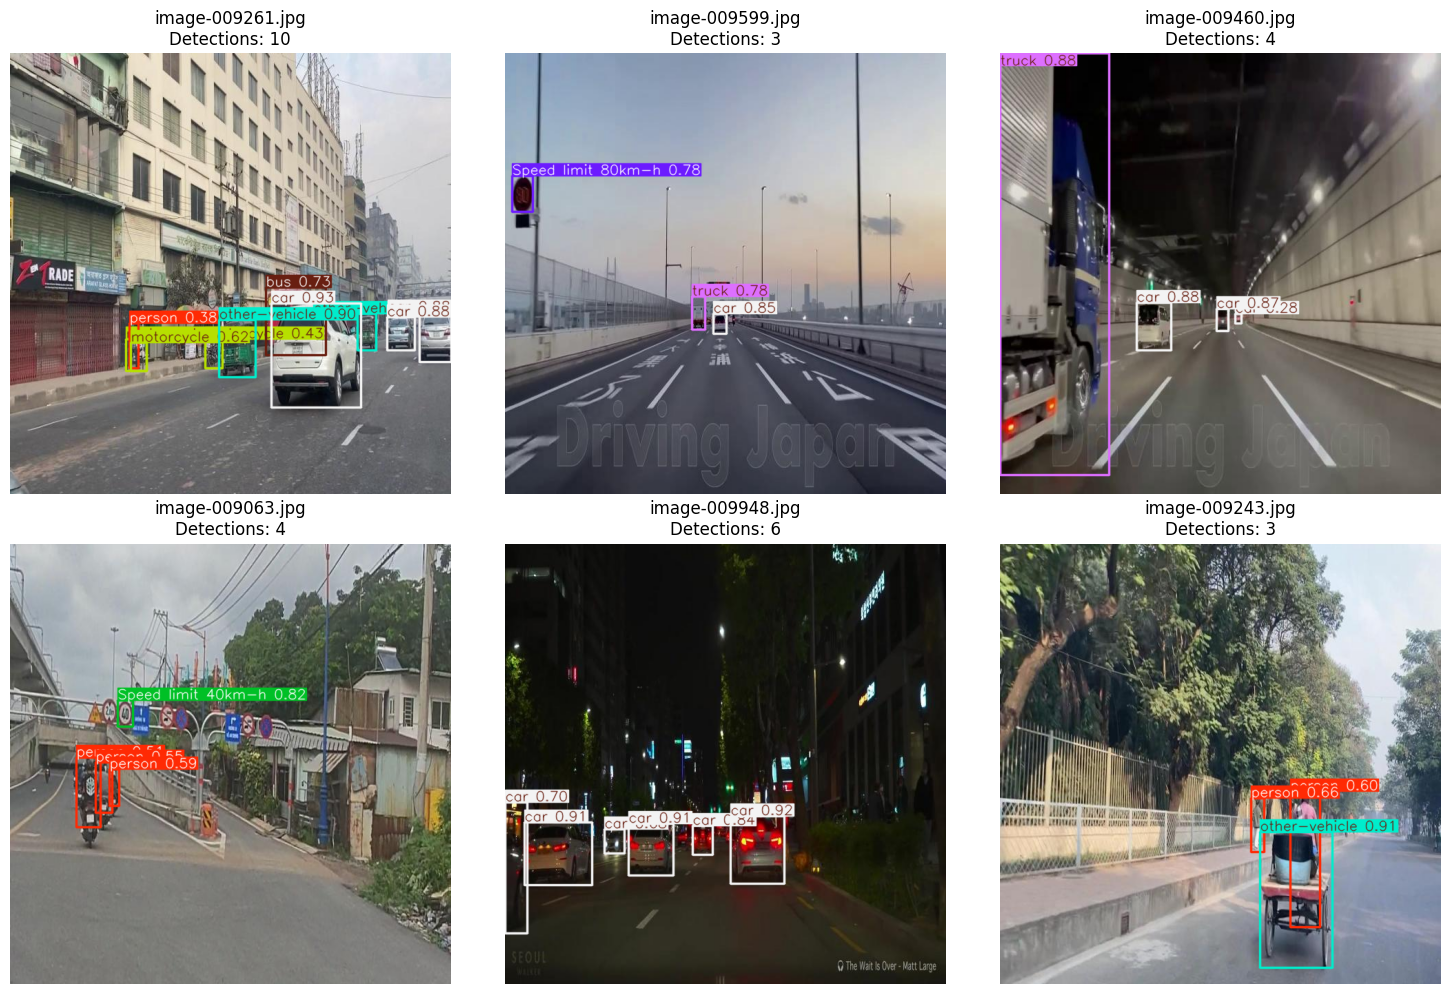


=== Detection Statistics ===
Total images processed: 952
Total detections: 4702

Detections per class:
  car: 2873
  other-vehicle: 269
  bus: 175
  motorcycle: 156
  person: 615
  truck: 354
  Speed limit 80km-h: 56
  Speed limit 40km-h: 26
  bicycle: 36
  Speed limit 30km-h: 7
  Speed limit 50km-h: 30
  Speed limit 60km-h: 61
  End of speed limit 80km-h: 3
  red light: 9
  green light: 29
  Speed limit 70km-h: 3


In [14]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load model
model = YOLO('models/train/weights/best.pt')

# Define test images directory
test_dir = Path('dataset/test/images')
if not test_dir.exists():
    print(f"Test directory {test_dir} not found!")
    exit()

# Get all image files
image_files = []
for ext in ['*.jpg', '*.jpeg', '*.png']:
    image_files.extend(list(test_dir.glob(ext)))

# Select up to 6 images for visualization
n_images_to_show = min(6, len(image_files))
selected_images = image_files[:n_images_to_show]

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Process each selected image
for idx, img_path in enumerate(selected_images):
    # Read and process image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run inference with batch=1
    results = model.predict(source=img, batch=1, verbose=False)
    result = results[0]

    # Draw boxes on the image
    annotated_img = result.plot()

    # Display image
    axes[idx].imshow(annotated_img)
    axes[idx].set_title(f'{img_path.name}\nDetections: {len(result.boxes)}')
    axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(selected_images), 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# === Detection Statistics for all test images ===
print("\n=== Detection Statistics ===")
total_detections = 0
class_counts = {}

for img_path in image_files:
    results = model.predict(source=str(img_path), batch=1, verbose=False)
    result = results[0]

    for box in result.boxes:
        cls = int(box.cls[0].item())  # get class index
        cls_name = model.names.get(cls, f'class_{cls}')
        class_counts[cls_name] = class_counts.get(cls_name, 0) + 1
        total_detections += 1

print(f"Total images processed: {len(image_files)}")
print(f"Total detections: {total_detections}\n")

print("Detections per class:")
for cls_name, count in class_counts.items():
    print(f"  {cls_name}: {count}")
